## Activity Classification 

In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
import scipy.io as sio
import itertools
from matplotlib import pyplot as plt
from scipy import interp
from sklearn.metrics import classification_report, roc_curve,  confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.jet):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_multi_ROC(y_test_enc, y_scores, class_map=None, lw=2, figsize=(8,6)):
    """
    Plot the ROC curve for the multi_class classification problem
    y_test_enc   : one hot encoder matrix for the target variable.
    y_scores     : classification problem or decision boundary
    n_classes    : class labels dictionary mapping each column of y_test_enc to a label
    lw           : line width
    figsize      : figure size
    """
    # number of classes
    n_classes = y_test_enc.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_enc[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_enc.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    
    
    # Plot all ROC curves
    plt.figure(figsize=figsize)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
    
    if class_map is None:
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))
    else:
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {} (area = {:.2f})'
                     ''.format(class_map[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Load data

Considered features: sample_mean, time_of_data_variation (secs), max_peak, num_peaks, mean_of_peaks, pse.

In [3]:
data = sio.loadmat('../data/num_data_aug.mat')['data']
# Remove not tagged instances (e.g., Enrico's low frequency gameplay)
# 0 is the code for not tagged data. 
data = data[data[:,-1] != 0]
print data

[[ 0.31612362  0.51076294  1.         ...,  1.19060919  3.42123432  1.        ]
 [ 0.23859909  0.30645777  1.         ...,  0.63196545  3.77933016  1.        ]
 [ 0.49870963  2.14520436  4.         ...,  6.29437589  2.68336024  3.        ]
 ..., 
 [ 0.49741322  3.27630447  6.         ...,  8.36395936  2.01679775  3.        ]
 [ 0.36464193  1.33099869  3.         ...,  3.3898593   2.84611253  2.        ]
 [ 0.57603441  2.45722835  4.         ...,  5.65549558  2.22981438  3.        ]]


In [4]:
X = data[:,:-2]  # Load X.
y = data[:,-1]   # Load y

#label remap
labels = {1: 'locally_moving', 2:'walk/strafe', 3:'running'}

## Machine Learning approach
---

### Random forest experiments

In [5]:
from sklearn import svm
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer

In [6]:
#### Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2) # 20% for the testing set

CROSS VALIDATION:
Accuracy: 0.86 (+/- 0.12) 	 <- The mean score and the 95% confidence interval of the score estimate!

CLASSIFICATION REPORT:
                precision    recall  f1-score   support

locally_moving       0.95      0.91      0.93        22
   walk/strafe       0.39      0.54      0.45        13
       running       0.86      0.77      0.81        39

   avg / total       0.80      0.77      0.78        74

Confusion matrix, without normalization


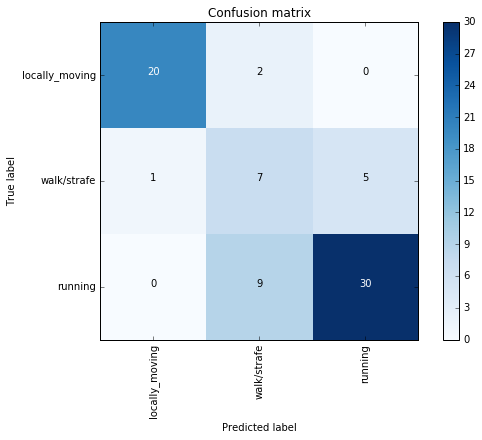

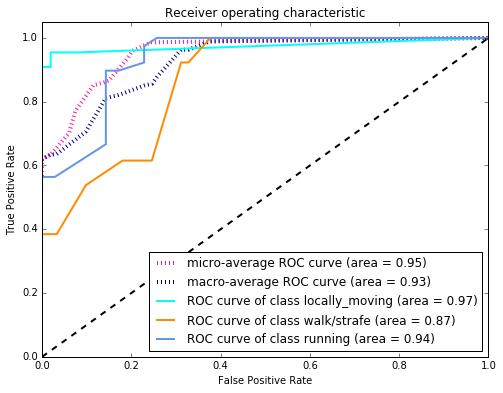

In [7]:
# Random forest classifier
clf = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
clf.fit(X_train, y_train)            # fit classifier
y_pred = clf.predict(X_test)         # one-hot predictions
y_scores = clf.predict_proba(X_test) # probabilistic predictions

# Cross validation
scores = cross_val_score(clf, X_train, y_train, cv=10)
print 'CROSS VALIDATION:'
print("Accuracy: %0.2f (+/- %0.2f) \t <- The mean score and the 95%% confidence interval of the score estimate!" % (scores.mean(), scores.std() * 2))

## One hot encoder for the multi-class target variable
lb = LabelBinarizer()             # define encoder
lb.fit(y_test)                    # fit enconder
y_test_enc = lb.transform(y_test) # get transformation

# define labels (for improved readability)
labls = [labels[i] for i in set(y_pred)]

print "\nCLASSIFICATION REPORT:"
print(classification_report(y_test, y_pred, target_names=labls))

# generate confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=labls,
                      title='Confusion matrix', normalize=False, cmap=plt.cm.Blues)

# Compute ROC curve and ROC area for each class
plot_multi_ROC(y_test_enc, y_scores,
               class_map={0: 'locally_moving', 1:'walk/strafe', 2:'running'},
               figsize=(8,6)
              )

## Conclusion

From the features we have and the classification method, we see that the result is pretty good. The ROC graph looks nice and definetly we are way better than a random guess. From the same graph, we see that detecting walk/strafe(dodging) is a litle bit hard. However, this is somewhat fine given the running/walk similarities. An interesting improvement study would be to use adaboost. 

## Fuzzy classification report
---

## Load data

In [ ]:
# load target variable
data = sio.loadmat('../data/num_data.mat')['data']
y_true = data[:,-1]
labels = {0: 'ignored', 1: 'locally_moving', 2:'walk/strafe', 3:'running'}

In [ ]:
fuzzy_data = np.array([i[0] for i in list(sio.loadmat('../data/fuzzy_ref4.mat')['ref_vec'])])

### Remove not tagged instances (e.g., Enrico's low frequency gameplay)
### 0 is the code for not tagged data. 
ex = [] # list of rows to exlude
for i in range(len(y_true)):
    if y_true[i] == 0.0:
        ex.append(i)
fuzzy_data = np.delete(fuzzy_data,ex)                 # exclude rows
y_true = np.array([int(i) for i in y_true if i != 0]) # clean target variable
# Check dimensions
print y_true.shape
print fuzzy_data.shape

In [ ]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    """
    Range remap fuction: remap a value from a given interval to another.
    value   : the value to be remaped
    leftMin : the lower original endpoint
    leftMax : the higher original endpoint
    rightMin: the lower modified endpoint
    rightMax: the higher modified endpint
    """
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [ ]:
## A simple deffuzification process considering the proportion of values: pick the 
# 'label' whose the output value is closest)!
for i in range(len(fuzzy_data)):
    if fuzzy_data[i] >= 0 and fuzzy_data[i] < 0.4:
        value = translate(fuzzy_data[i], 0, 0.4, 0, 1)
        if (value > .5):
            fuzzy_data[i] = 1
        else:
            fuzzy_data[i] = 0
    elif fuzzy_data[i] >= 0.4 and fuzzy_data[i] < 0.8:
        value = translate(fuzzy_data[i], 0.4, 0.8, 0, 1)
        if (value > .5):
            fuzzy_data[i] = 2
        else:
            fuzzy_data[i] = 1
    elif fuzzy_data[i] >= 0.8 and fuzzy_data[i] <= 1:
        value = translate(fuzzy_data[i], 0.8, 0.1, 0, 1)
        if (value > .5):
            fuzzy_data[i] = 3
        else:
            fuzzy_data[i] = 2

In [ ]:
y_pred = np.array(fuzzy_data)
labels = {0: 'ignored', 1: 'locally_moving', 2:'walk/strafe', 3:'running'}
target_names = [labels[i] for i in list(set(fuzzy_data))]

print "CLASSIFICATION REPORT:"
print(classification_report(y_true, y_pred, target_names=target_names))
# make confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
# Plot normalized confusion matrix
plt.figure(figsize=(8,4))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix', cmap=plt.cm.Blues)

## Conclusion
---

Current designed system is not as accurate as using Random Forest classifier! Needs to be redisigned. Naturally, we should not consider it anymore since we have better classification methods! In case we need a probabilistic prediction, we can just use that type of output from the random forest!